# Typhoon Prediction Project
* Predict the trajectory of typhoons
    * 6h, 12h, 18h, 24h, ...
* LSTM, GRU

In [1]:
import pandas as pd
# from pandas.core.common import SettingWithCopyWarning
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import mean_absolute_error, f1_score
from sklearn.model_selection import train_test_split
from torch.autograd import Variable


pd.set_option('mode.chained_assignment', None)
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    device = 'cpu'
    print('CUDA is not available. Training on CPU...')
else:
    device = 'cuda'

## 전처리

### 데이터 형식변환

In [2]:
## 전처리
def drop_str(data):
    cnt=0
    for y,m,d,t in zip(data["Year"],data["Month"],data["Date"],data["Time"]):
            data["Year"][cnt] = y.split("년")[0]
            data["Month"][cnt] = m.split("월")[0]
            data["Date"][cnt] = d.split("일")[0]
            data["Time"][cnt] = t.split("시")[0]
            cnt+=1
    return data
def str2int(data):
    data["Year"]=0
    data["Month"]=0
    data["Date"]=0
    data["Time"]=0
    for i, element in enumerate(data["일시"]):
        data["Year"][i]=element.split(' ')[0]
        data["Month"][i]=element.split(' ')[1]
        data["Date"][i]=element.split(' ')[2]
        data["Time"][i]=element.split(' ')[3]
    return data
def cat_1(data):
    strength_map={}
    for i, s in enumerate(data["강도"].unique()):
        strength_map[s] = i
    data["강도"] = data["강도"].map(strength_map)
    return data
def cat_2(data):
    for i, s in enumerate(data["크기"]):
        if s=="-":
            data["크기"][i] = 0
        elif s=="소형":
            data["크기"][i] = 1
        elif s=="중형":
            data["크기"][i] = 2
        else:
            data["크기"][i] = 3
    return data
def prepro(data):
    idx = data[data["Unnamed: 1"]!=0].index
    data = data.drop(idx)
    data = data.reset_index()
    data = str2int(data)
    drop_str(data)
    data =cat_1(data)
    data =cat_2(data)
    data = data.drop(["진행방향","70% 확률 반경(km)", "Unnamed: 1","일시","index"], axis=1)
    return data

In [3]:
data_dir = "./Typhoon/tp_"
data = []

In [4]:
## csv 순서대로읽어와서 data에 저장
for i in range(1,529):
    data.append(pd.read_csv(data_dir+str(i).zfill(3)+".csv",encoding_errors='ignore',encoding="cp949"))

In [5]:
for i in range(len(data)):
    data[i]=prepro(data[i])
    data[i].insert(0,'ID', i)

In [30]:
### The longest time series length
min=999
max=0
a = 0
for i in range(len(data)):
    if max < data[i].shape[0]:
        max = data[i].shape[0]
    if min > data[i].shape[0]:
        min = data[i].shape[0]
    a += data[i].shape[0]
print(a/len(data))
print(min)
print(max)

17.783681214421254
2
74


In [7]:
for i in range(len(data)):
    data[i] = data[i].drop(["Year","Month","Date","Time"],axis=1)

In [8]:
for i in range(len(data)):
    data[i] = data[i].drop(["ID"],axis=1)

In [9]:
# ## latitude, Longitude
# y1=[]
# y2=[]
# for i in range(len(data)):
#     y1.append(data[i]["위도(N)"])
#     y2.append(data[i]["경도(E)"])
#     data[i] = data[i].drop(["위도(N)","경도(E)"],axis=1)

In [10]:
for i in range(len(data)):
    data[i] = data[i].fillna(0)

In [11]:
np.max(data[509][['중심기압']].values)

1000

### 정규화

In [12]:
data[3]

,위도(N),경도(E),중심기압,초속(m/s),시속(km/h),강풍반경(km)[예외반경],강도,크기,이동속도(km/h)
0,10.6,137.4,990.0,21.0,76.0,740.0,0,3,18.0
1,14.0,131.6,980.0,25.0,90.0,850.0,1,3,30.0
2,16.0,127.1,970.0,35.0,126.0,850.0,2,3,40.0
3,18.3,124.0,965.0,35.0,126.0,850.0,2,3,25.0
4,19.1,120.6,965.0,38.0,137.0,810.0,2,3,25.0
5,20.4,118.5,965.0,36.0,130.0,750.0,2,3,26.0
6,20.9,116.9,970.0,28.0,101.0,650.0,1,3,5.0
7,23.0,114.6,975.0,23.0,83.0,450.0,0,2,25.0
8,23.2,113.2,980.0,21.0,76.0,400.0,0,2,21.0
9,23.4,112.2,985.0,0.0,0.0,0.0,3,3,20.0


In [13]:
minmax = {}
for j in ['위도(N)','경도(E)','중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','강도','크기','이동속도(km/h)']:
    m = np.inf
    M = -np.inf
    for i in range(len(data)):
        m = m if np.min(data[i][[j]].values) > m else np.min(data[i][[j]].values)
        # if m == -1 :
        #     print(i, end = ' ')
    for i in range(len(data)):
        M = M if np.max(data[i][[j]].values) < M  else np.max(data[i][[j]].values)
    minmax[j] = [m,M]
    print('min', m)
    print('max', M)

min 1.6
max 54.0
min 99.8
max 180.0
min 0
max 1010
min -1
max 61
min -4
max 220
min 0
max 1480.0
min 0
max 5
min 0
max 3
min 0.0
max 216


In [14]:
# sc = MinMaxScaler()
# for i in range(len(data)):
#     data[i][['위도(N)','경도(E)','중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','강도','크기','이동속도(km/h)']]=sc.fit_transform(data[i][['위도(N)','경도(E)','중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','강도','크기','이동속도(km/h)']])
minmax['위도(N)'][0], minmax['위도(N)'][1] = 0, 60
minmax['경도(E)'][0], minmax['경도(E)'][1] = 0, 180

for i in range(len(data)):
    for j in ['위도(N)','경도(E)','중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','강도','크기','이동속도(km/h)']:
        data[i][j] = (data[i][j] - minmax[j][0])/(minmax[j][1] - minmax[j][0])


In [15]:
len(data)

528

In [16]:
data[1]

,위도(N),경도(E),중심기압,초속(m/s),시속(km/h),강풍반경(km)[예외반경],강도,크기,이동속도(km/h)
0,0.218333,0.738889,0.986139,0.306452,0.308036,0.101351,0.0,0.333333,0.101852
1,0.251667,0.706111,0.980198,0.387097,0.388393,0.222973,0.0,0.666667,0.092593
2,0.325000,0.679444,0.955446,0.548387,0.549107,0.304054,0.2,0.666667,0.138889
3,0.368333,0.663889,0.945545,0.629032,0.629464,0.304054,0.2,0.666667,0.115741
4,0.413333,0.663333,0.965347,0.467742,0.468750,0.135135,0.4,0.333333,0.125000
5,0.441667,0.663889,0.975248,0.387097,0.388393,0.135135,0.0,0.333333,0.138889
6,0.470000,0.670000,0.985149,0.354839,0.357143,0.135135,0.0,0.333333,0.162037
7,0.501667,0.677778,0.988119,0.338710,0.339286,0.101351,0.0,0.333333,0.185185
8,0.525000,0.682222,0.988119,0.338710,0.339286,0.101351,0.0,0.333333,0.231481
9,0.538333,0.692222,0.990099,0.258065,0.258929,0.000000,0.6,1.000000,0.277778


### Window Dataset

In [17]:
class windowDataset(Dataset):
    def __init__(self, data, input_window, output_window,
                 in_features = ['위도(N)','경도(E)','중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','강도','크기','이동속도(km/h)'],
                 out_features = ['위도(N)','경도(E)'], stride=1):
        deletion = []
        num_samples = 0
        
        #총 데이터의 개수
        #inputwindow + outputwindow 보다 짧은 길이의 태풍들은 데이터에서 제거해줌.
        for i, d in enumerate(data):
            if(len(d) < input_window + output_window):
                deletion.append(i)
                continue
            #stride씩 움직일 때 생기는 총 sample의 개수
            #태풍별로 확인해줄 예정이니 각 태풍마다의 sample개수를 구하여 전부 더해줌.
            num_samples += (len(d) - input_window - output_window) // stride + 1
        print('number of useable data : ', len(data)-len(deletion))
        for i in deletion[::-1]:
            del data[i]
        #in feature의 개수와 out feature의 개수 저장
        num_in_feature = len(in_features)
        num_out_feature = len(out_features)

        #input과 output : shape = (window 크기, sample 개수, feature 개수)
        X = np.zeros([input_window, num_samples, num_in_feature])
        Y = np.zeros([output_window, num_samples, num_out_feature])

        j = 0
        for d in data:
            #data별로 불러옴
            for i in range((len(d) - (input_window + output_window))// stride + 1):
                #각 데이터의 길이를 확인하고 각 데이터별로 input_window와 output_window에따른
                #활용가능한 학습용 데이터의 길이를 확인함
                #각 태풍별로 input_window와 output_window에 따른 학습용 데이터를 추출함.
                start_x = stride*i
                end_x = start_x + input_window
                X[:,j] = d[start_x:end_x][in_features]
                
                start_y = stride*i + input_window
                end_y = start_y + output_window
                Y[:,j] = d[start_y:end_y][out_features]
                j += 1

        #추출한 데이터를 Dataset 형식에 맞추어 reshape
        X = X.reshape(X.shape[0], X.shape[1], num_in_feature).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], num_out_feature).transpose((1,0,2))
        self.x = X.astype(np.float32)
        self.y = Y.astype(np.float32)
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

## 모델 정의

### 모델 class

In [18]:
class simpleLSTM(nn.Module):
    def __init__(self, n_input, n_output, n_hidden=256, n_layers=2, dropout_prob=0.5):
        super().__init__()
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(n_input, n_hidden, n_layers, dropout=dropout_prob, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(n_hidden, n_output)
        
    def forward(self, x, hidden):
        out, hidden = self.lstm(x,hidden)
        out = self.dropout(out)
        out = out.contiguous().view(-1, self.n_hidden)
        out = self.fc(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        return hidden

### Training

In [19]:
def train(net, data, epochs=10, batch_size = 10, in_window = 3, out_window=1, lr=0.0001):
    valid_loss_min = np.Inf
    train_loss = torch.zeros(epochs)
    valid_loss = torch.zeros(epochs)
    
    net.to(device)
    net.train()
    
    # Define optimizer
    optim = torch.optim.Adam(net.parameters(),lr=lr)
    # Define loss function
    criterion = nn.MSELoss()
    
    # Define traning and validation data
    # 90% of the data is used for traning set and 10% for validation set
    val_inx = int(len(data)*0.9)
    data, val_data = data[:val_inx], data[val_inx:]
    
    train_dataset = windowDataset(data, in_window, out_window)
    valid_dataset = windowDataset(val_data, in_window, out_window)
    train_loader = DataLoader(train_dataset, batch_size)
    valid_loader = DataLoader(valid_dataset, batch_size)
    
    for e in tqdm(range(epochs)):
        net.train()
        for x, y in train_loader:
            batch = x.shape[0]
            h = net.init_hidden(batch)
            x, y = x.to(device), y.reshape(y.shape[0], -1).to(device)
            
            optim.zero_grad()
            
            logits, h = net(x, h)
            
            loss = criterion(logits[-batch:,:], y)

            loss.backward(retain_graph=True)
            optim.step()
            
            train_loss[e] = train_loss[e] + loss.item()
        train_loss[e] = train_loss[e] / len(train_loader)
        with torch.no_grad():
            net.eval()
            for x, y in valid_loader:
                batch = x.shape[0]
                h = net.init_hidden(batch)
                
                x, y = x.to(device), y.reshape(y.shape[0], -1).to(device)

                logits, h = net(x, h)

                loss = criterion(logits[-batch:,:], y)

                valid_loss[e] =  valid_loss[e] + loss.item()

            valid_loss[e] =valid_loss[e] / len(valid_loader)
        
        print("Epoch : {}\tTraining Loss: {:.6f}\tValidation Loss: {:.6f}".format(e, train_loss[e], valid_loss[e]))
       
        if valid_loss[e] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} ==> {:.6f}).\tSaving model ...'.format(valid_loss_min, valid_loss[e]))
            valid_loss_min = valid_loss[e]
    
    return train_loss, valid_loss

### Initialize model

In [37]:
n_hidden=32
n_layers=2
net = simpleLSTM(9 ,2, n_hidden, n_layers)
net.to(device)
print(net)

simpleLSTM(
  (lstm): LSTM(9, 32, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)


## Train Model

In [21]:
test = data[521]
del data[521]

In [38]:
train_loss, validation_loss = train(net, data, epochs=100, batch_size = 50, in_window = 7, out_window=1, lr=0.0001)

number of useable data :  370
number of useable data :  47


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 0	Training Loss: 0.416131	Validation Loss: 0.335485
Validation loss decreased (inf ==> 0.335485).	Saving model ...
Epoch : 1	Training Loss: 0.244731	Validation Loss: 0.125638
Validation loss decreased (0.335485 ==> 0.125638).	Saving model ...
Epoch : 2	Training Loss: 0.132480	Validation Loss: 0.090357
Validation loss decreased (0.125638 ==> 0.090357).	Saving model ...
Epoch : 3	Training Loss: 0.114211	Validation Loss: 0.076949
Validation loss decreased (0.090357 ==> 0.076949).	Saving model ...
Epoch : 4	Training Loss: 0.099816	Validation Loss: 0.065211
Validation loss decreased (0.076949 ==> 0.065211).	Saving model ...
Epoch : 5	Training Loss: 0.087381	Validation Loss: 0.054823
Validation loss decreased (0.065211 ==> 0.054823).	Saving model ...
Epoch : 6	Training Loss: 0.074825	Validation Loss: 0.046653
Validation loss decreased (0.054823 ==> 0.046653).	Saving model ...
Epoch : 7	Training Loss: 0.065309	Validation Loss: 0.039968
Validation loss decreased (0.046653 ==> 0.039968)

## test model

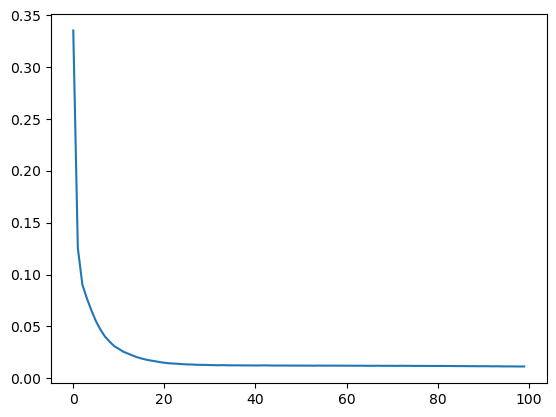

In [39]:
plt.plot(validation_loss)

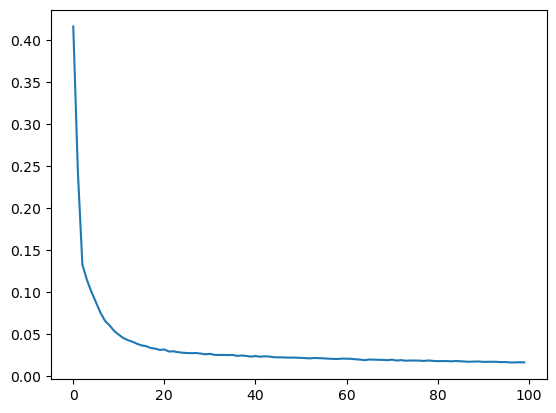

In [40]:
plt.plot(train_loss)

In [23]:
Hin_Y = pd.concat([test['위도(N)'],test['경도(E)']],axis=1)
Hin_X = test.drop(['위도(N)','경도(E)'],axis=1)

In [24]:
Hin_Y

,위도(N),경도(E)
0,0.448333,0.825000
1,0.453333,0.816667
2,0.455000,0.806667
3,0.456667,0.796111
4,0.455000,0.784444
5,0.451667,0.773889
6,0.446667,0.762778
7,0.446667,0.752222
8,0.441667,0.742222
9,0.438333,0.732778


In [25]:
for j in ['중심기압','초속(m/s)','시속(km/h)','강풍반경(km)[예외반경]','강도','크기','이동속도(km/h)']:
        Hin_X[j] = (Hin_X[j] - minmax[j][0])/(minmax[j][1] - minmax[j][0])

In [26]:
Hin_X = Hin_X.values.reshape(-1,44,7).astype(np.float32)

In [27]:
Hin_X = torch.tensor(Hin_X, dtype=torch.float32)

In [28]:
h = net.init_hidden(1)
out,_ = net(Hin_X.to(device), h)

RuntimeError: input.size(-1) must be equal to input_size. Expected 9, got 7

In [ ]:
out[:,0]

In [ ]:
(out[:,0].to('cpu')) * (minmax['위도(N)'][1] - minmax['위도(N)'][0]) + minmax['위도(N)'][0]

In [ ]:
(out[:,1].to('cpu')) * (minmax['경도(E)'][1] - minmax['경도(E)'][0]) + minmax['경도(E)'][0]

In [ ]:
(Hin_Y[:]['위도(N)']) * (minmax['위도(N)'][1] - minmax['위도(N)'][0]) + minmax['위도(N)'][0]

In [ ]:

(Hin_Y[:]['경도(E)']) * (minmax['경도(E)'][1] - minmax['경도(E)'][0]) + minmax['경도(E)'][0]